<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/pytorch/1_12_cnn_Fashion-MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Load CIFAR-10 Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
filePath ="/content/gdrive/MyDrive/neural_data/"

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='filePath', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='filePath', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 72080958.67it/s]


Extracting filePath/cifar-10-python.tar.gz to filePath
Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: filePath
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: filePath
    Split: Test
    StandardTransform
Transform: ToTensor()

### Create Loaders

In [ ]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Define strings for labels

In [ ]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

### View a batch of Images

Label: [    0     2     7     8     7     5     4     6     0     3]
Class:  plane  bird horse  ship horse   dog  deer  frog plane   cat


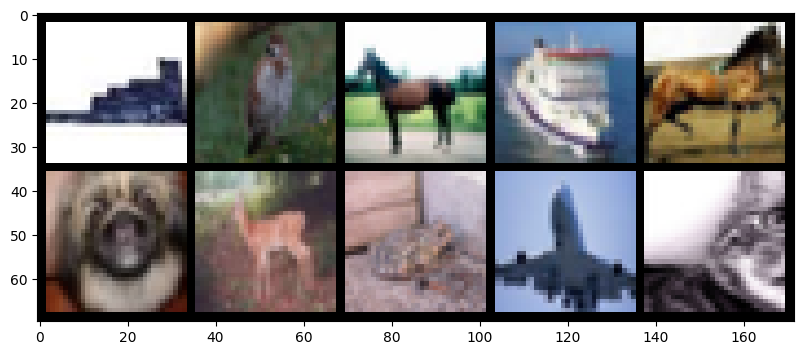

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the model

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
______
 81302


## Define loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.73764265  accuracy:  24.360%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 2.22016764  accuracy:  30.840%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.39087522  accuracy:  34.530%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.69324040  accuracy:  37.413%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.91142690  accuracy:  39.798%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.45302713  accuracy:  50.470%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.06807518  accuracy:  51.320%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.44415414  accuracy:  52.150%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.99543399  accuracy:  52.475%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 0.96994114  accuracy:  52.878%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.26145816  accuracy:  56.490%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.04823899  accuracy:  56.900%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.17224598  accuracy:  56.957%
epoch:  2  b

In [ ]:
# save model
# torch.save(model.state_dict(), 'CIFAR10-CNN-Model.pt')

## Plot loss and accuracy

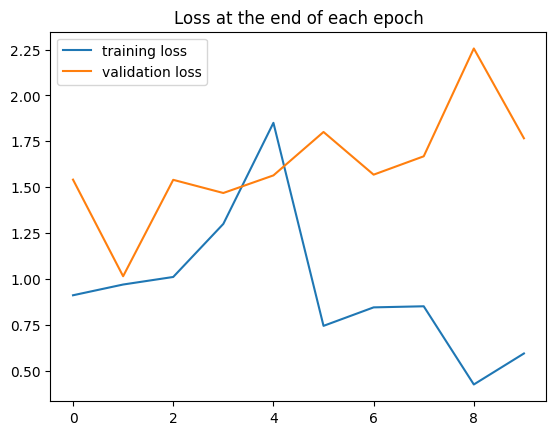

In [ ]:
plt.plot([loss.item() for loss in train_losses], label='training loss')
plt.plot([loss.item() for loss in test_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

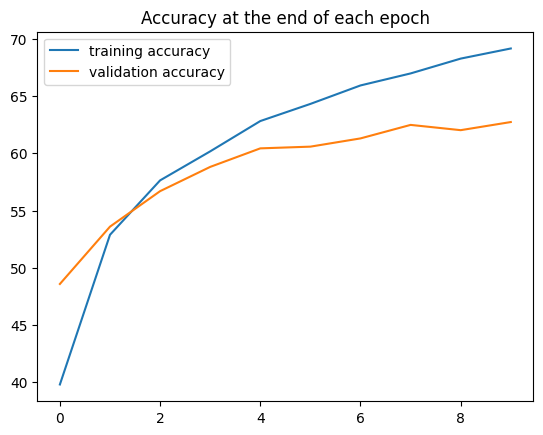

In [ ]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [ ]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4858), tensor(5359), tensor(5669), tensor(5881), tensor(6043), tensor(6058), tensor(6130), tensor(6248), tensor(6202), tensor(6273)]

Test accuracy: 62.730%


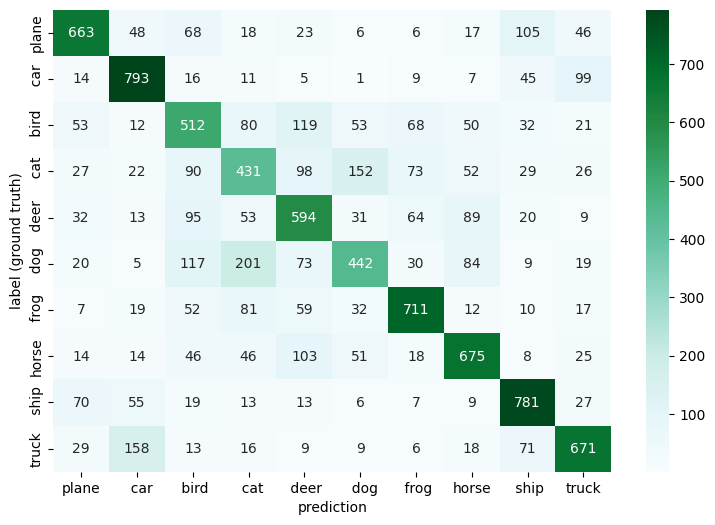

In [ ]:
import seaborn as sn  # for heatmaps

# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();